In [1]:

import dgl
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from time import time
import torch
import warnings
import yfinance as yf

from utils import build_nx_graph, gen_q_dict_mis, qubo_dict_to_torch, \
    get_gnn, run_gnn_training, loss_func, postprocess_gnn_mis, run_mis_solver
from utils_backtest import portfolio_return, drawdown, sharpe_ratio, sortino_ratio, \
    max_drawdown, calmar_ratio
from utils_backtest import annualized_sharpe_ratio, annualized_sortino_ratio, \
    annualized_max_drawdown, annualized_calmar_ratio
from utils_distance_correlation import dcor

warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


In [3]:
METHOD = 'pct'
CORR_METHOD = 'pearson'
THRESHOLD = 0.5

## Read in Data

In [4]:
sp500_hist = pd.read_csv(
    "sp500_hist_prices.csv",
    parse_dates=['Date'],
    index_col='Date'
)

sp500_hist = sp500_hist.loc['2014-01-01':,]
sp500_hist.dropna(axis=1, inplace=True)


print(f'Shape: {sp500_hist.shape}')
sp500_hist.head()

Shape: (2266, 470)


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.141602,23.907921,101.185295,17.388981,35.240082,60.504734,31.847378,19.123333,68.658348,59.290001,...,169.137527,20.609207,66.582367,44.643036,30.301586,45.261662,83.170258,53.180000,24.822664,30.329689
2014-01-03,37.610752,25.020359,104.080498,17.007023,35.457024,60.548027,32.188923,18.756666,68.886833,59.160000,...,167.479828,20.601709,66.422142,44.857124,30.576576,45.544949,83.530914,53.580002,24.998468,30.039131
2014-01-06,37.425739,25.482304,103.084709,17.099760,34.162140,60.331593,32.613773,18.580000,68.159042,58.119999,...,167.360214,20.489336,66.522278,44.587177,30.523350,45.508789,84.071892,53.400002,24.822664,29.973518
2014-01-07,37.960957,25.369169,104.357124,16.977465,34.229923,60.989532,32.363853,18.586666,68.988396,58.970001,...,172.188049,20.841444,67.463448,45.276005,30.612062,46.147724,85.749016,53.950001,24.898008,30.085989
2014-01-08,38.582062,26.047947,103.545738,17.084980,34.141792,61.586887,32.655426,18.476667,69.521561,58.900002,...,175.417999,20.759035,67.243179,45.359783,30.594316,46.129646,87.849907,53.910000,25.115677,29.748577


### S&P500 as Benchmark

In [5]:
gspc = yf.download(
    tickers="^GSPC", 
    start=sp500_hist.index[0].strftime(format="%Y-%m-%d"), 
    end=sp500_hist.index[-1].strftime(format="%Y-%m-%d")
)['Adj Close']

gspc

[*********************100%***********************]  1 of 1 completed


Date
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
2014-01-08    1837.489990
                 ...     
2022-12-22    3822.389893
2022-12-23    3844.820068
2022-12-27    3829.250000
2022-12-28    3783.219971
2022-12-29    3849.280029
Name: Adj Close, Length: 2265, dtype: float64

In [6]:
TRAIN_START_DATE, TRAIN_END_DATE = "2014-01-01", "2019-01-01"
VAL_START_DATE, VAL_END_DATE = TRAIN_END_DATE, "2021-01-01"
TEST_START_DATE, TEST_END_DATE = VAL_END_DATE, "2022-12-30"

df_train = sp500_hist.loc[TRAIN_START_DATE:TRAIN_END_DATE,:]
df_val = sp500_hist.loc[VAL_START_DATE:VAL_END_DATE,:]
df_test = sp500_hist.loc[TEST_START_DATE:TEST_END_DATE,:]

gspc_train = gspc.loc[TRAIN_START_DATE:TRAIN_END_DATE]
gspc_val = gspc.loc[VAL_START_DATE:VAL_END_DATE]
gspc_test = gspc.loc[TEST_START_DATE:TEST_END_DATE]

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

assert df_train.shape[1] == df_val.shape[1] and df_val.shape[1] == df_test.shape[1]
assert df_train.shape[0] == gspc_train.shape[0] 
assert df_val.shape[0] == gspc_val.shape[0]
assert df_test.shape[0] == gspc_test.shape[0] + 1


Train shape: (1258, 470)
Validation shape: (505, 470)
Test shape: (503, 470)


In [7]:
df_train

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.141602,23.907921,101.185295,17.388981,35.240082,60.504734,31.847378,19.123333,68.658348,59.290001,...,169.137527,20.609207,66.582367,44.643036,30.301586,45.261662,83.170258,53.180000,24.822664,30.329689
2014-01-03,37.610752,25.020359,104.080498,17.007023,35.457024,60.548027,32.188923,18.756666,68.886833,59.160000,...,167.479828,20.601709,66.422142,44.857124,30.576576,45.544949,83.530914,53.580002,24.998468,30.039131
2014-01-06,37.425739,25.482304,103.084709,17.099760,34.162140,60.331593,32.613773,18.580000,68.159042,58.119999,...,167.360214,20.489336,66.522278,44.587177,30.523350,45.508789,84.071892,53.400002,24.822664,29.973518
2014-01-07,37.960957,25.369169,104.357124,16.977465,34.229923,60.989532,32.363853,18.586666,68.988396,58.970001,...,172.188049,20.841444,67.463448,45.276005,30.612062,46.147724,85.749016,53.950001,24.898008,30.085989
2014-01-08,38.582062,26.047947,103.545738,17.084980,34.141792,61.586887,32.655426,18.476667,69.521561,58.900002,...,175.417999,20.759035,67.243179,45.359783,30.594316,46.129646,87.849907,53.910000,25.115677,29.748577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,60.658115,29.247074,138.501755,35.375175,68.045486,66.140617,60.909603,24.799999,125.596710,205.160004,...,88.352982,42.943733,52.057148,33.934464,58.313515,80.661499,91.214142,142.899994,33.992252,77.151306
2018-12-26,63.435974,31.776182,144.184326,37.866352,71.991089,68.271782,64.681641,25.920000,130.614197,222.949997,...,95.286011,43.792011,54.544388,35.590034,61.059139,83.414490,95.707779,152.520004,35.757629,80.693588
2018-12-27,64.345779,31.530161,143.868149,37.620605,72.694519,68.729797,65.619980,26.540001,131.929657,225.139999,...,94.220131,44.165985,54.782780,35.607304,62.085175,84.313622,95.641960,155.350006,35.713490,82.065712


### Build correlation matrix

In [20]:
# if METHOD == 'standard':
#     df_corr = df_train.corr(method=CORR_METHOD).abs()
# elif METHOD == 'pct':
#     df_train_pct = df_train.pct_change()
#     df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
# elif METHOD == 'pct_yearly':
#     df_train_pct = df_train.pct_change()
#     df_train_pct = df_train_pct.groupby(df_train_pct.index.year).sum()
#     df_corr = df_train_pct.corr(method=CORR_METHOD).abs()
# elif METHOD == 'drawdown':
#     df_mdd = df_train.apply(lambda x: drawdown(x))
#     df_corr = df_mdd.corr(method=CORR_METHOD).abs()
# else:
#     raise KeyError("METHOD must be either 'standard', 'pct' or 'pct_yearly'.")

# Daily returns
df_train_pct = df_train.pct_change()
df_corr_daily = df_train_pct.corr(method=CORR_METHOD).abs()

# Weekly returns
df_train_pct_w = df_train_pct.groupby(pd.Grouper(freq='W')).sum()
df_corr_weekly = df_train_pct_w.corr(method=CORR_METHOD).abs()

# Monthly returns
df_train_pct_m = df_train_pct.groupby(pd.Grouper(freq='W')).sum()
df_corr_monthly = df_train_pct_m.corr(method=CORR_METHOD).abs()

# Drawdowns

# Final correlation matrix
df_corr = (df_corr_daily + df_corr_weekly + df_corr_monthly) / 3
df_corr

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
A,1.000000,0.380509,0.205689,0.407145,0.420144,0.377327,0.581908,0.339587,0.581371,0.488265,...,0.343519,0.087687,0.404072,0.412029,0.550957,0.412910,0.419751,0.405604,0.454703,0.527046
AAL,0.380509,1.000000,0.221541,0.216751,0.205785,0.304483,0.324151,0.294744,0.343569,0.311580,...,0.225295,0.025651,0.197722,0.298263,0.356416,0.256672,0.289253,0.289128,0.353985,0.280114
AAP,0.205689,0.221541,1.000000,0.192574,0.241295,0.249852,0.276148,0.223379,0.281877,0.237417,...,0.108183,0.142806,0.225211,0.228410,0.231524,0.276707,0.244995,0.254915,0.310872,0.183381
AAPL,0.407145,0.216751,0.192574,1.000000,0.257527,0.240947,0.426138,0.201798,0.412007,0.437592,...,0.234472,0.055491,0.273566,0.278704,0.336519,0.347009,0.306799,0.358062,0.300788,0.386241
ABBV,0.420144,0.205785,0.241295,0.257527,1.000000,0.397635,0.544066,0.192280,0.329309,0.343095,...,0.231281,0.131031,0.306011,0.385868,0.362668,0.287810,0.460156,0.260242,0.285158,0.461170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.412910,0.256672,0.276707,0.347009,0.287810,0.245078,0.386645,0.268109,0.396842,0.411473,...,0.177308,0.183433,0.296394,0.259181,0.427741,1.000000,0.268127,0.370433,0.340422,0.377862
ZBH,0.419751,0.289253,0.244995,0.306799,0.460156,0.312328,0.495990,0.290393,0.371386,0.351941,...,0.237297,0.138207,0.306470,0.353772,0.288211,0.268127,1.000000,0.227813,0.288229,0.372716
ZBRA,0.405604,0.289128,0.254915,0.358062,0.260242,0.243392,0.360512,0.222294,0.388301,0.333765,...,0.320167,0.010656,0.305520,0.112331,0.353608,0.370433,0.227813,1.000000,0.357611,0.358522
ZION,0.454703,0.353985,0.310872,0.300788,0.285158,0.311060,0.381315,0.401031,0.431830,0.290693,...,0.164362,0.125331,0.391506,0.275572,0.483077,0.340422,0.288229,0.357611,1.000000,0.316800


In [21]:
df_corr_daily.quantile(0.5).mean()

0.2980208683115972

In [ ]:
STOCK_NAMES = df_corr.columns.values

## Build Graph

In [ ]:
nx_graph = build_nx_graph(
    df_corr=df_corr,
    threshold=THRESHOLD
)

# assert nx.is_connected(nx_graph), 'Graph is not connected. Try to lower the threshold'
assert (df_corr.where(df_corr >= THRESHOLD).count().sum() - len(df_corr)) / 2 == len(nx_graph.edges)

In [ ]:
len(nx_graph.edges)

5406

### Plot degree distribution

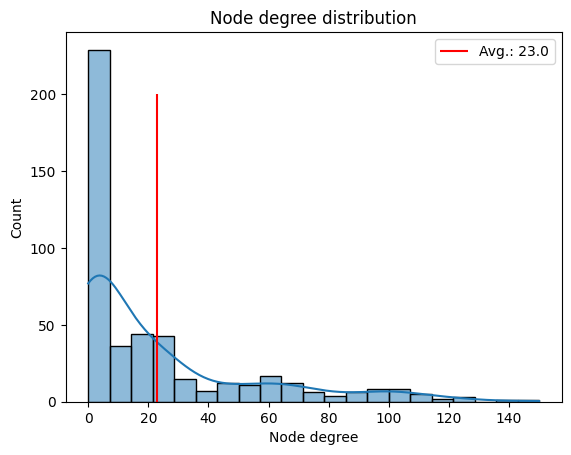

In [ ]:
degrees = [degree for (node, degree) in nx_graph.degree()]
avg_degree = sum(degrees) / len(degrees)

sns.histplot(degrees, kde=True)
plt.vlines(avg_degree, ymin=0, ymax=200, colors=['r'], label=f"Avg.: {avg_degree:.1f}")
plt.title("Node degree distribution")
plt.xlabel("Node degree")
plt.legend()
plt.show()

### Build Q matrix

In [ ]:
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

gen_q_dict_mis(nx_graph)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(
    nx_graph, 
    gen_q_dict_mis(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

### Visualize graph

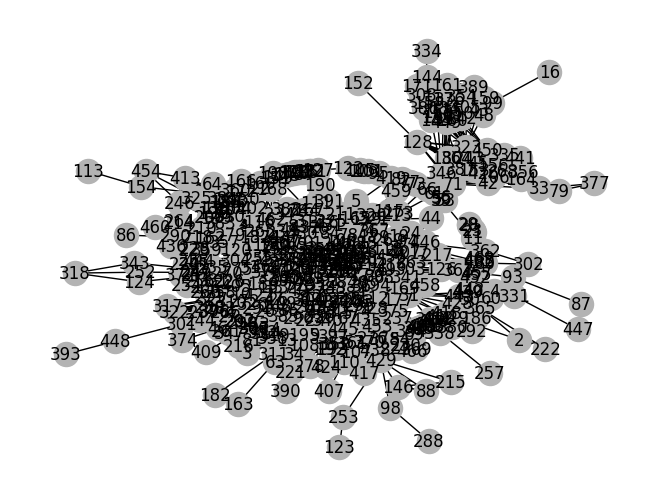

In [ ]:
if len(nx_graph.nodes) < 500:
    pos = nx.kamada_kawai_layout(nx_graph)
    nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Set up GNN

In [ ]:
# best set of parameters according to 
# hyperparameter tuning

params = {'lr': 0.0001,
 'dim_embedding': 22,
 'hidden_dim': 11,
 'dropout': 0.05,
 'number_classes': 1,
 'prob_threshold': 0.5,
 'number_epochs': 30000,
 'tolerance': 0.0001,
 'patience': 1000,
 'model': 'SAGE_2L_Model'}

In [ ]:
n = len(nx_graph.nodes)

net, embed, optimizer = get_gnn(
    n_nodes=n,
    params=params, 
    model_type='SAGE_2L_Model', 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE
)

net

SAGE_2L_Model(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=22, out_features=22, bias=True)
    (fc_neigh): Linear(in_features=22, out_features=11, bias=False)
    (fc_self): Linear(in_features=22, out_features=11, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=11, out_features=11, bias=True)
    (fc_neigh): Linear(in_features=11, out_features=1, bias=False)
    (fc_self): Linear(in_features=11, out_features=1, bias=True)
  )
)

## Run GNN training

In [ ]:
print('Running GNN...')
gnn_start = time()

net, embed, optimizer = get_gnn(
    n_nodes=n, 
    params=params, 
    model_type=params["model"], 
    torch_device=TORCH_DEVICE, 
    torch_dtype=TORCH_DTYPE)   
    
net, epoch, final_bitstring, best_bitstring, best_loss, inputs, loss_hist, epoch_hist = run_gnn_training(
    q_torch=q_torch, 
    dgl_graph=graph_dgl, 
    net=net, 
    embed=embed, 
    optimizer=optimizer, 
    number_epochs=params['number_epochs'],
    tol=params['tolerance'], 
    patience=params['patience'], 
    prob_threshold=params['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -36.27659606933594
Epoch: 1000, Loss: -106.58497619628906
Epoch: 2000, Loss: -147.20973205566406
Epoch: 3000, Loss: -159.8602294921875
Epoch: 4000, Loss: -160.8619842529297
Epoch: 5000, Loss: -160.26199340820312
Epoch: 6000, Loss: -173.16888427734375
Epoch: 7000, Loss: -162.17977905273438
Epoch: 8000, Loss: -184.45069885253906
Epoch: 9000, Loss: -191.0403289794922
Epoch: 10000, Loss: -194.35806274414062
Epoch: 11000, Loss: -194.52989196777344
Epoch: 12000, Loss: -195.7673797607422
Epoch: 13000, Loss: -195.72732543945312
Epoch: 14000, Loss: -195.9052734375
Epoch: 15000, Loss: -195.91395568847656
Epoch: 16000, Loss: -195.87525939941406
Epoch: 17000, Loss: -195.9661102294922
Epoch: 18000, Loss: -195.991943359375
Epoch: 19000, Loss: -195.94798278808594
Epoch: 20000, Loss: -195.9774169921875
Epoch: 21000, Loss: -195.99607849121094
Epoch: 22000, Loss: -195.99684143066406
Epoch: 23000, Loss: -195.95896911621094
Epoch: 24000, Loss: -195.99557495117188
Epoch: 2500

## Post-process GNN Results

In [ ]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mis_gnn, ind_set_gnn, number_violations_gnn = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis_gnn} with {number_violations_gnn} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 196 with 0 violations
Took 294.44s, model training took 294.259s


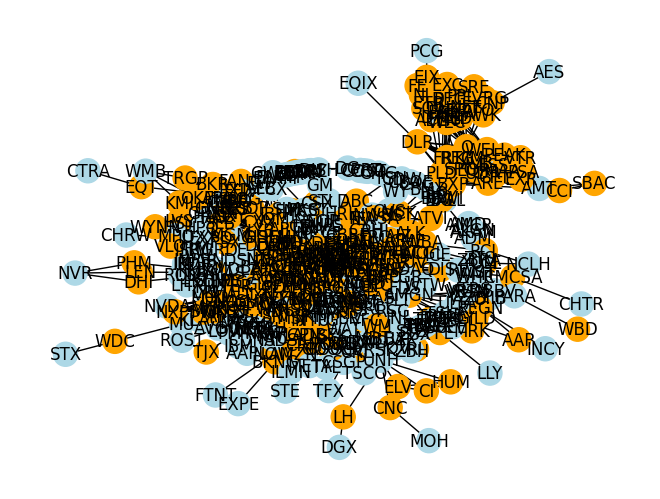

In [ ]:
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx_graph_labelled = nx.relabel_nodes(nx_graph, lambda x: STOCK_NAMES[x])
pos_labelled = nx.kamada_kawai_layout(nx_graph_labelled)
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [ ]:
gnn_mis_set = STOCK_NAMES[np.argwhere(best_bitstring == 1)].tolist()[0]

## Compare against traditional solver

In [ ]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, number_violations_nx, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {number_violations_nx} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=470).
Calculating violations...
Independence number found by nx solver is 194 with 0 violations.
MIS solver took 32.108s


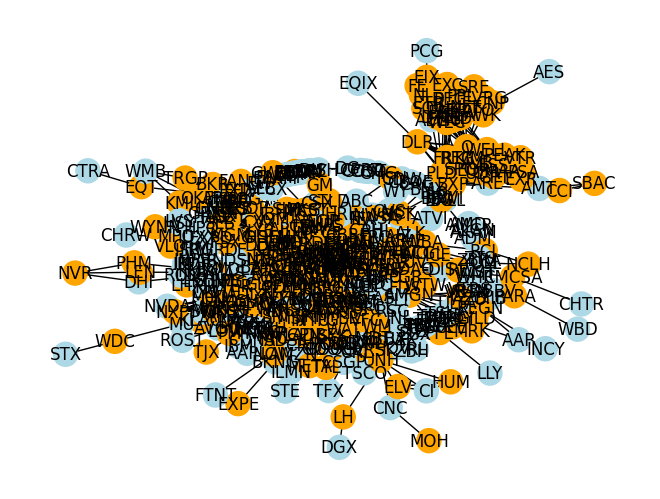

In [ ]:
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map)

In [ ]:
solver_mis_set = STOCK_NAMES[np.argwhere(torch.tensor(ind_set_bitstring_nx) == 1)].tolist()[0]

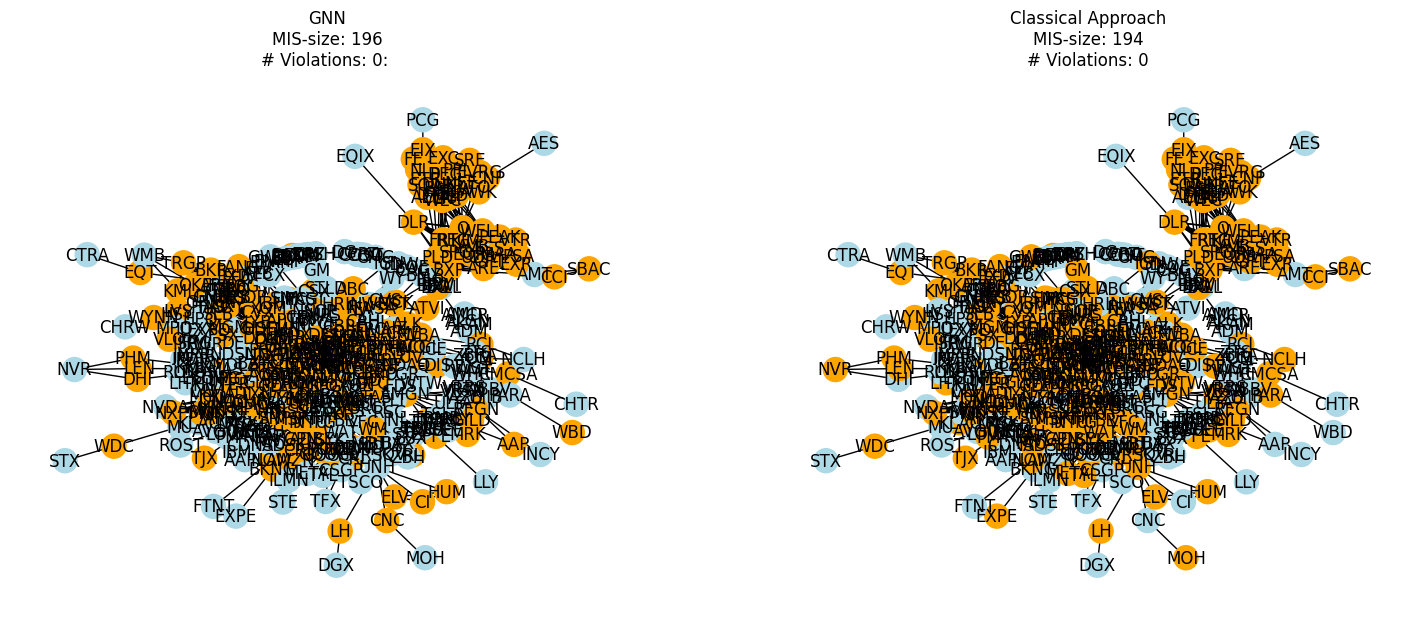

In [ ]:
_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

# GNN
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax0)
ax0.set_title(f"GNN\nMIS-size: {size_mis_gnn}\n# Violations: {number_violations_gnn}: ")

# MIS algo (classic approach)
color_map = ['orange' if (ind_set_bitstring_nx[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph_labelled, pos_labelled, with_labels=True, node_color=color_map, ax=ax1)
ax1.set_title(f"Classical Approach\nMIS-size: {ind_set_nx_size}\n# Violations: {number_violations_nx}")
plt.show()

In [ ]:
df_mis = pd.concat([
    pd.DataFrame(
        data={'gnn': gnn_mis_set},
        index=gnn_mis_set
    ),
    pd.DataFrame(
        data={'solver': solver_mis_set},
        index=solver_mis_set
    )
],
axis=1)

len(df_mis)

242

In [ ]:
# intersection
df_intersec = df_mis.dropna(axis=0)
print(f"Length: {len(df_intersec)}")
# df_intersec

Length: 148


In [ ]:
len(df_intersec) / ((size_mis_gnn.item() + ind_set_nx_size) /2 )

0.7589743589743589

In [ ]:
# Not intersecting
df_non_intersec = df_mis.drop(index=df_intersec.index)
print(f"Length: {len(df_non_intersec)}")
# df_non_intersec

Length: 94


## Backtest

In [ ]:
RISK_FREE_RATE = 0.01

In [ ]:
def drawdown_pct(return_series):
    rs_max = return_series.rolling(
        window=len(return_series), 
        min_periods=1
        ).max()
    return return_series - rs_max

### Training

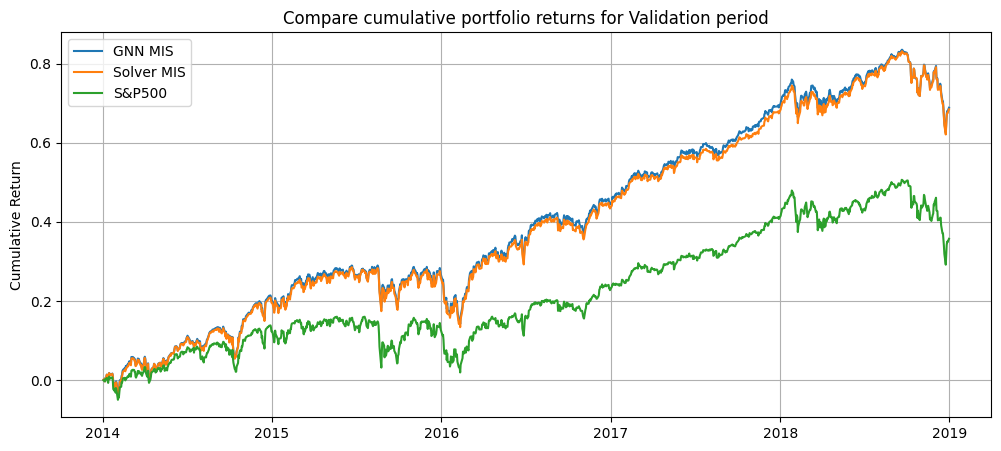

In [ ]:
# GNN MIS Portfolio
gnn_mis_returns_train, gnn_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_train, solver_mis_returns_cum_train = portfolio_return(
    df=df_train,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_train = gspc_train.pct_change()
gspc_returns_cum_train = gspc_returns_train.cumsum()

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_train, label="GNN MIS")
plt.plot(solver_mis_returns_cum_train, label="Solver MIS")
plt.plot(gspc_returns_cum_train, label="S&P500")

plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

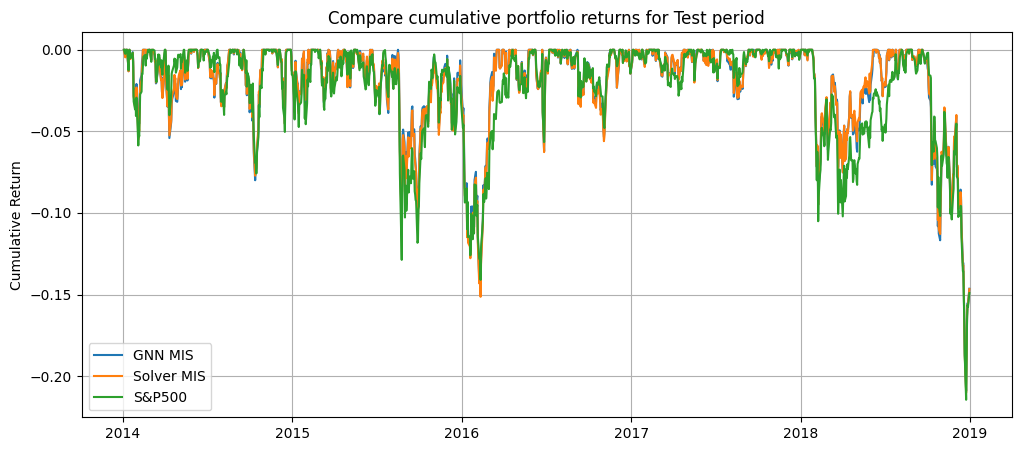

In [ ]:
gnn_mis_mdd_train = drawdown_pct(gnn_mis_returns_cum_train)
solver_mis_mdd_train = drawdown_pct(solver_mis_returns_cum_train)
gspc_mdd_train = drawdown_pct(gspc_returns_cum_train)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_train, label="GNN MIS")
plt.plot(solver_mis_mdd_train, label="Solver MIS")
plt.plot(gspc_mdd_train, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Sharpe Ratios
df_sharpe_train = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sharpe_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sharpe_train['Avg'] = df_sharpe_train.mean(axis=1)
# df_sharpe_train.index.rename('Sharpe', inplace=True)
df_sharpe_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_train.index), df_sharpe_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_train.index = multi_idx
df_sharpe_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                    
Sharpe GNN        1.57  0.38  1.13  3.09 -0.07  1.22
       Classic    1.53  0.36  1.11  3.06  0.00  1.21
       SP500      1.00 -0.03  0.68  2.54 -0.35  0.77

In [ ]:
# Sortino Ratios
df_sortino_train = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sortino_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sortino_train['Avg'] = df_sortino_train.mean(axis=1)
# df_sortino_train.index.rename('Sortino', inplace=True)
df_sortino_train.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_train.index), df_sortino_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_train.index = multi_idx
df_sortino_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric  Portfolio                                    
Sortino GNN        2.06  0.54  1.47  4.48 -0.08  1.69
        Classic    2.02  0.50  1.45  4.35  0.00  1.67
        SP500      1.30 -0.05  0.89  3.41 -0.43  1.03

In [ ]:
# Maximal Draw Down
df_mdd_train = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_returns_train, name='GNN'),
    annualized_max_drawdown(df_returns=solver_mis_returns_train, name='Classic'),
    annualized_max_drawdown(df_returns=gspc_returns_train, name='SP500')
], axis=1).T

df_mdd_train['Avg'] = df_mdd_train.mean(axis=1)
# df_mdd_train.index.rename('MDD', inplace=True)
df_mdd_train.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_train.index), df_mdd_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_train.index = multi_idx
df_mdd_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                    
MDD    GNN       -0.08 -0.11 -0.15 -0.03 -0.21 -0.11
       Classic   -0.08 -0.11 -0.15 -0.03 -0.21 -0.12
       SP500     -0.08 -0.13 -0.14 -0.03 -0.21 -0.12

In [ ]:
# Calmar Ratios
df_calmar_train = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_train, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_calmar_ratio(df_returns=gspc_returns_train, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_calmar_train['Avg'] = df_calmar_train.mean(axis=1)
# df_calmar_train.index.rename('Calmar', inplace=True)
df_calmar_train.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_train.index), df_calmar_train.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_train.index = multi_idx
df_calmar_train.round(2)

2014  2015  2016  2017  2018   Avg
Metric Portfolio                                    
Calmar GNN        2.39  0.53  1.12  7.77 -0.05  2.35
       Classic    2.41  0.49  1.08  7.81  0.00  2.36
       SP500      1.49 -0.04  0.64  6.03 -0.28  1.57

### Validation

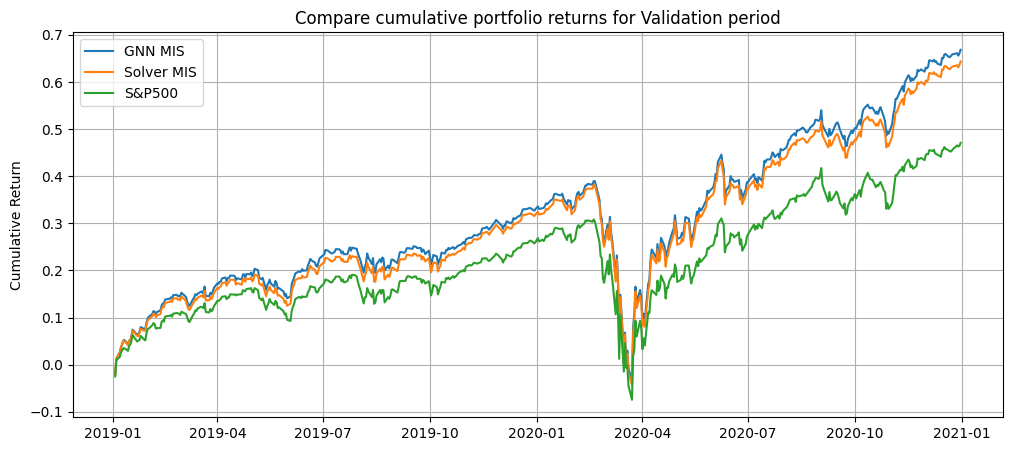

In [ ]:
# GNN MIS Portfolio
gnn_mis_returns_val, gnn_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_val, solver_mis_returns_cum_val = portfolio_return(
    df=df_val,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_val = gspc_val.pct_change()
gspc_returns_cum_val = gspc_returns_val.cumsum()

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_val, label="GNN MIS")
plt.plot(solver_mis_returns_cum_val, label="Solver MIS")
plt.plot(gspc_returns_cum_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Validation period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

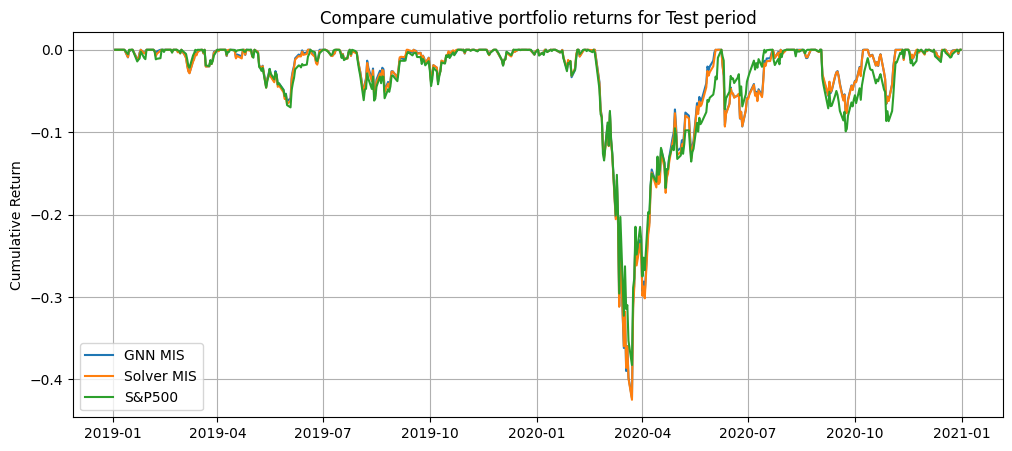

In [ ]:
gnn_mis_mdd_val = drawdown_pct(gnn_mis_returns_cum_val)
solver_mis_mdd_val = drawdown_pct(solver_mis_returns_cum_val)
gspc_mdd_val = drawdown_pct(gspc_returns_cum_val)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_val, label="GNN MIS")
plt.plot(solver_mis_mdd_val, label="Solver MIS")
plt.plot(gspc_mdd_val, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Sharpe Ratios
df_sharpe_val = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sharpe_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sharpe_val['Avg'] = df_sharpe_val.mean(axis=1)
df_sharpe_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_val.index), df_sharpe_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_val.index = multi_idx
df_sharpe_val.round(2)

2019  2020   Avg
Metric Portfolio                  
Sharpe GNN        2.51  0.92  1.72
       Classic    2.41  0.89  1.65
       SP500      2.01  0.58  1.29

In [ ]:
# Sortino Ratios
df_sortino_val = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sortino_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sortino_val['Avg'] = df_sortino_val.mean(axis=1)
df_sortino_val.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_val.index), df_sortino_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_val.index = multi_idx
df_sortino_val.round(2)

2019  2020   Avg
Metric  Portfolio                  
Sortino GNN        3.24  1.02  2.13
        Classic    3.11  0.99  2.05
        SP500      2.48  0.66  1.57

In [ ]:
# Maximal Draw Down
df_mdd_val = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_returns_val, name='GNN'),
    annualized_max_drawdown(df_returns=solver_mis_returns_val, name='Classic'),
    annualized_max_drawdown(df_returns=gspc_returns_val, name='SP500')
], axis=1).T

df_mdd_val['Avg'] = df_mdd_val.mean(axis=1)
df_mdd_val.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_val.index), df_mdd_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_val.index = multi_idx
df_mdd_val.round(2)

2019  2020   Avg
Metric Portfolio                  
MDD    GNN       -0.06 -0.42 -0.24
       Classic   -0.07 -0.42 -0.25
       SP500     -0.07 -0.38 -0.23

In [ ]:
# Calmar Ratios
df_calmar_val = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_val, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_calmar_ratio(df_returns=gspc_returns_val, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_calmar_val['Avg'] = df_calmar_val.mean(axis=1)
df_calmar_val.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_val.index), df_calmar_val.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_val.index = multi_idx
df_calmar_val.round(2)

2019  2020   Avg
Metric Portfolio                  
Calmar GNN        5.12  0.78  2.95
       Classic    4.69  0.74  2.72
       SP500      3.58  0.52  2.05

### Test

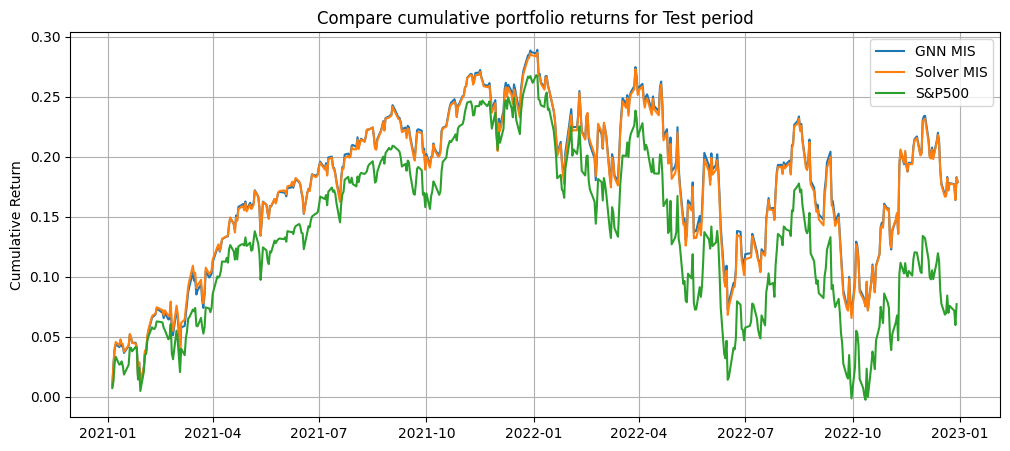

In [ ]:
# GNN MIS Portfolio
gnn_mis_returns_test, gnn_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=gnn_mis_set
)

# Solver MIS Portfolio
solver_mis_returns_test, solver_mis_returns_cum_test = portfolio_return(
    df=df_test,
    assets=solver_mis_set
)

# Benchmark S&P500
gspc_returns_test = gspc_test.pct_change()
gspc_returns_cum_test = gspc_returns_test.cumsum()

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_returns_cum_test, label="GNN MIS")
plt.plot(solver_mis_returns_cum_test, label="Solver MIS")
plt.plot(gspc_returns_cum_test, label="S&P500")
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

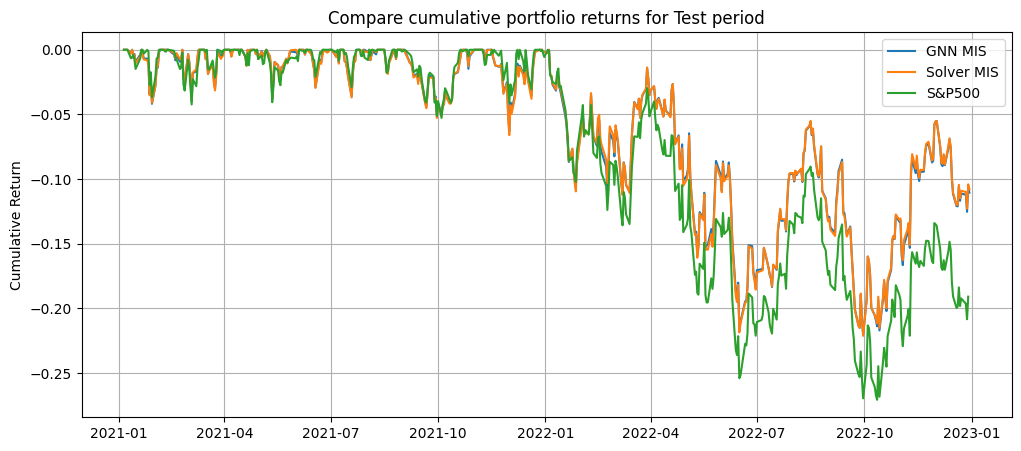

In [ ]:
gnn_mis_mdd_test = drawdown_pct(gnn_mis_returns_cum_test)
solver_mis_mdd_test = drawdown_pct(solver_mis_returns_cum_test)
gspc_mdd_test = drawdown_pct(gspc_returns_cum_test)

# Plot
plt.subplots(figsize=(12,5))
plt.plot(gnn_mis_mdd_test, label="GNN MIS")
plt.plot(solver_mis_mdd_test, label="Solver MIS")
plt.plot(gspc_mdd_test, label="S&P500")
# plt.hlines(0, xmin=gnn_mis_mdd_test.index[0], xmax=gnn_mis_mdd_test.index[-1])
plt.title("Compare cumulative portfolio returns for Test period")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Sharpe Ratios
df_sharpe_test = pd.concat([
    annualized_sharpe_ratio(df_returns=gnn_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sharpe_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sharpe_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sharpe_test['Avg'] = df_sharpe_test.mean(axis=1)
df_sharpe_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sharpe']*len(df_sharpe_test.index), df_sharpe_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sharpe_test.index = multi_idx
df_sharpe_test.round(2)

2021  2022   Avg
Metric Portfolio                  
Sharpe GNN        2.11 -0.49  0.81
       Classic    2.08 -0.48  0.80
       SP500      1.93 -0.81  0.56

In [ ]:
# Sortino Ratios
df_sortino_test = pd.concat([
    annualized_sortino_ratio(df_returns=gnn_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_sortino_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_sortino_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_sortino_test['Avg'] = df_sortino_test.mean(axis=1)
df_sortino_test.columns.rename('', inplace=True)
multi_idx = np.array([['Sortino']*len(df_sortino_test.index), df_sortino_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_sortino_test.index = multi_idx
df_sortino_test.round(2)

2021  2022   Avg
Metric  Portfolio                  
Sortino GNN        3.06 -0.82  1.12
        Classic    3.03 -0.79  1.12
        SP500      2.75 -1.29  0.73

In [ ]:
# Maximal Draw Down
df_mdd_test = pd.concat([
    annualized_max_drawdown(df_returns=gnn_mis_returns_test, name='GNN'),
    annualized_max_drawdown(df_returns=solver_mis_returns_test, name='Classic'),
    annualized_max_drawdown(df_returns=gspc_returns_test, name='SP500')
], axis=1).T

df_mdd_test['Avg'] = df_mdd_test.mean(axis=1)
df_mdd_test.columns.rename('', inplace=True)
multi_idx = np.array([['MDD']*len(df_mdd_test.index), df_mdd_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_mdd_test.index = multi_idx
df_mdd_test.round(2)

2021  2022   Avg
Metric Portfolio                  
MDD    GNN       -0.06 -0.22 -0.14
       Classic   -0.07 -0.22 -0.14
       SP500     -0.05 -0.27 -0.16

In [ ]:
# Calmar Ratios
df_calmar_test = pd.concat([
    annualized_calmar_ratio(df_returns=gnn_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='GNN'),
    annualized_calmar_ratio(df_returns=solver_mis_returns_test, risk_free_rate=RISK_FREE_RATE, name='Classic'),
    annualized_calmar_ratio(df_returns=gspc_returns_test, risk_free_rate=RISK_FREE_RATE, name='SP500')
], axis=1).T

df_calmar_test['Avg'] = df_calmar_test.mean(axis=1)
df_calmar_test.columns.rename('', inplace=True)
multi_idx = np.array([['Calmar']*len(df_calmar_test.index), df_calmar_test.index.values])
multi_idx = pd.MultiIndex.from_arrays(multi_idx, names=('Metric', 'Portfolio'))
df_calmar_test.index = multi_idx
df_calmar_test.round(2)

2021  2022   Avg
Metric Portfolio                  
Calmar GNN        4.39 -0.54  1.93
       Classic    4.16 -0.52  1.82
       SP500      4.78 -0.72  2.03